# MSBI Final Project -- Framingham Dataset

Authors: Kevin Munoz & Kate Johnson


#### Importing Relevant Libraries

In [1]:
#for data cleaning/general use
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt

#for logistic models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from scipy.stats import sem
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import partial_dependence


#for ANN models
import sklearn.preprocessing as pp
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier as mlpc
from sklearn.model_selection import GridSearchCV

#for RF model
from sklearn.ensemble import RandomForestClassifier 
from math import isqrt

#get rid of warnings
import warnings
warnings.simplefilter('ignore') #some weird warnings kept popping up and I think this fixes it

## Setting Up Useful Functions

In [2]:
seed = 27 # set global seed

#def auc confidence interval function for later
def AUC_CI(X_test,y_test,model, prob=True):
    
    y_true = np.array(y_test)
    
    if prob == True:
        y_pred = np.array(model.predict_proba(X_test)[:,1])
    else:
        y_pred = np.array(model.predict(X_test))
    
    print("Original AUC area: {:0.3f}".format(roc_auc_score(y_true, y_pred)))

    n_bootstraps = 1000
    rng_seed = seed  # control reproducibility
    bootstrapped_scores = []

    rng = np.random.RandomState(rng_seed)
    
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
            continue

        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
    
    #plot
    plt.hist(bootstrapped_scores, bins=50)
    plt.title('Histogram of the bootstrapped ROC AUC scores')
    plt.show()

    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()

    # Computing the lower and upper bound of the 95% confidence interval
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    print("Confidence interval for the score: [{:0.3f} - {:0.3f}]".format(
    confidence_lower, confidence_upper))
    return(roc_auc_score(y_true, y_pred), confidence_lower, confidence_upper, "{:0.3f}".format(roc_auc_score(y_true, y_pred)) + " ({:0.3f}".format(confidence_lower) + ", {:0.3f}".format(confidence_upper) + ")")
    
    

## Load Data

#### Import csv files from pre-processed R files.

In [3]:
wd = '/Users/Kate/Documents/2021/Spring_Quarter_2021/MSBI/Final_Project'

#data before standardization
#from reading in the data it looks like the first col is an index, so adjusting accordingly
d_train = pd.read_csv((wd+'/d.train.csv'), index_col=0)
d_test = pd.read_csv((wd+'/d.test.csv'), index_col=0)

#data after standardization
trainTransformed = pd.read_csv((wd+'/trainTransformed.csv'), index_col=0)
testTransformed = pd.read_csv((wd+'/testTransformed.csv'), index_col=0)

In [4]:
#quick vis of data
d_train.head()

,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
1,1,39,4,0,0,0,0,0,0,195,106.0,70.0,26.97,80,77,0
3,1,48,1,1,20,0,0,0,0,245,127.5,80.0,25.34,75,70,0
5,0,46,3,1,23,0,0,0,0,285,130.0,84.0,23.10,85,85,0
7,0,63,1,0,0,0,0,0,0,205,138.0,71.0,33.11,60,85,1
9,1,52,1,0,0,0,0,1,0,260,141.5,89.0,26.36,76,79,0


In [5]:
d_test.head()

,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
2,0,46,2,0,0,0,0,0,0,250,121.0,81.0,28.73,95,76,0
4,0,61,3,1,30,0,0,1,0,225,150.0,95.0,28.58,65,103,1
6,0,43,2,0,0,0,0,1,0,228,180.0,110.0,30.30,77,99,0
8,0,45,2,1,20,0,0,0,0,313,100.0,71.0,21.68,79,78,0
17,1,48,3,1,10,0,0,1,0,232,138.0,90.0,22.37,64,72,0


In [6]:
trainTransformed.head()

,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
4185.0,1,-1.031486,1,1,1.081409,0,0,0,0,-0.196850,-0.100680,0.172733,0.858859,0.983120,-0.375717,0
52.0,1,-0.150463,4,0,-0.805822,0,0,0,0,-0.523487,-1.157746,-1.608074,-0.527992,1.150391,0.164115,0
3515.0,0,0.856421,0,0,-0.805822,0,0,0,0,0.803475,-0.038500,-0.282822,0.748926,0.314039,-0.267750,0
4169.0,0,1.234003,1,0,-0.805822,1,0,1,0,1.701726,1.661096,1.870712,1.943394,-0.104136,-0.138191,0
2913.0,0,-1.660789,2,0,-0.805822,0,0,0,0,0.211446,-0.618850,0.048490,-1.105142,-0.104136,0.120929,0


In [7]:
testTransformed.head()

,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
2,0,-0.779765,2,0,-0.805822,0,0,0,0,0.170616,-0.784664,-0.365651,0.584026,1.568566,-0.246157,0
4,0,1.108142,3,1,2.025025,0,0,1,0,-0.339753,0.417489,0.793945,0.552314,-0.940488,0.336861,1
6,0,-1.157347,2,0,-0.805822,0,0,1,0,-0.278509,1.661096,2.036368,0.915940,0.063134,0.250488,0
8,0,-0.905626,2,1,1.081409,0,0,0,0,1.456748,-1.655189,-1.193933,-0.906417,0.230404,-0.202971,0
17,1,-0.528044,3,1,0.137793,0,0,1,0,-0.196850,-0.079953,0.379803,-0.760544,-1.024123,-0.332530,0


Should probably consider doing a .describe() just to make sure I'm looking at the same data as pre-processed R files

In [8]:
#record categorical variables (will also help if we do XGBoost later)
categories = ['education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'diabetes', 'sex', 'TenYearCHD']

train_cat, test_cat = d_train, d_test
dfs = train_cat, test_cat

for df in dfs:
    for category in categories:
        df[[category]] = df[[category]].astype('category')

In [9]:
train_cat.describe(include='all')

,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,3392.0,3392.000000,3392.0,3392.0,3392.000000,3392.0,3392.0,3392.000000,3392.0,3392.000000,3392.000000,3392.000000,3392.000000,3392.000000,3392.000000,3392.0
unique,2.0,NaN,5.0,2.0,NaN,2.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0
top,0.0,NaN,1.0,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
freq,1932.0,NaN,1389.0,1737.0,NaN,3297.0,3373.0,NaN,3308.0,NaN,NaN,NaN,NaN,NaN,NaN,2876.0
mean,NaN,49.466981,NaN,NaN,8.774469,NaN,NaN,0.306604,NaN,233.852300,132.163031,82.782429,25.717989,75.769458,74.306309,NaN
std,NaN,8.538882,NaN,NaN,11.796771,NaN,NaN,0.461151,NaN,52.181576,21.970603,11.864447,4.469057,12.141597,32.297336,NaN
min,NaN,32.000000,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,0.000000,83.500000,48.000000,0.000000,0.000000,0.000000,NaN
25%,NaN,42.000000,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,205.000000,117.000000,74.500000,23.070000,68.000000,68.000000,NaN
50%,NaN,49.000000,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,232.000000,128.000000,82.000000,25.405000,75.000000,77.000000,NaN
75%,NaN,56.000000,NaN,NaN,20.000000,NaN,NaN,1.000000,NaN,263.000000,143.000000,89.500000,28.040000,83.000000,85.000000,NaN


In [10]:
test_cat.describe(include='all')

,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,846.0,846.00000,846.0,846.0,846.000000,846.0,846.0,846.000000,846.0,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.0
unique,2.0,NaN,5.0,2.0,NaN,2.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0
top,0.0,NaN,1.0,1.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
freq,487.0,NaN,331.0,439.0,NaN,817.0,840.0,NaN,821.0,NaN,NaN,NaN,NaN,NaN,NaN,718.0
mean,NaN,50.05792,NaN,NaN,9.611111,NaN,NaN,0.326241,NaN,234.235225,133.111702,83.338652,25.559397,76.228132,75.088652,NaN
std,NaN,8.69334,NaN,NaN,12.301203,NaN,NaN,0.469114,NaN,46.920456,22.303612,12.091966,4.222661,11.837608,35.084857,NaN
min,NaN,33.00000,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,0.000000,92.500000,50.000000,0.000000,48.000000,0.000000,NaN
25%,NaN,42.00000,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,207.000000,117.125000,75.000000,22.910000,68.250000,68.000000,NaN
50%,NaN,49.00000,NaN,NaN,1.000000,NaN,NaN,0.000000,NaN,235.000000,129.000000,82.000000,25.290000,75.000000,77.000000,NaN
75%,NaN,57.75000,NaN,NaN,20.000000,NaN,NaN,1.000000,NaN,262.000000,145.000000,90.000000,27.997500,82.000000,86.000000,NaN


# Logistic Regression Model 

### (Untransformed Data)

Best parameters found:
 {'solver': 'lbfgs'}
Original AUC area: 0.660


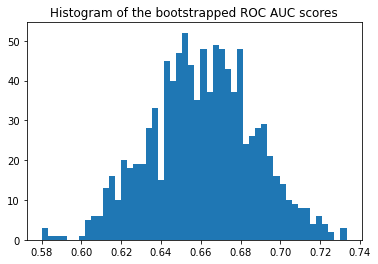

Confidence interval for the score: [0.611 - 0.712]


In [11]:
#label encoding categorical variables
le= LabelEncoder()
categories = ['education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'diabetes', 'sex', 'TenYearCHD']

dfs = d_train, d_test

#use one hot encoding for outcome since xgb.DMatrix doesnt support categorical labels
for df in dfs:
    for category in categories:
        df[category] = le.fit_transform(df[category])

#setting X_train and y_train 
X_train = d_train.drop(columns='TenYearCHD')
y_train = d_train['TenYearCHD']

#also setting X_test and y_test while we're at it
X_test = d_test.drop(columns='TenYearCHD')
y_test = d_test['TenYearCHD']

#setting up grid search for CV
logistic = LogisticRegression(penalty='none') #consider adding penalty to param space with l1 and l2 options
parameter_space = { 'solver': ['lbfgs', 'sag']}
clf = GridSearchCV(logistic, parameter_space, scoring='roc_auc', n_jobs=-1, cv=5)
                
#fit data
clf.fit(X_train, y_train) # X is train samples and y is the corresponding labels
print('Best parameters found:\n', clf.best_params_)

#display & record AUC
LR_AUC, CL, CU, words = AUC_CI(X_test, y_test, clf)

#create empty dict for storing all model AUCs
models = {}
models['LR'] = [clf.best_params_, words, LR_AUC, CL, CU]

## Lasso Regression 

### (Untransformed data)

Best parameters found:
 {'alpha': 0.0001}
Original AUC area: 0.726


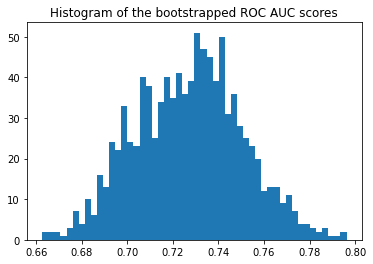

Confidence interval for the score: [0.682 - 0.773]


In [12]:
#setting X_train and y_train 
X_train = d_train.drop(columns='TenYearCHD')
y_train = d_train['TenYearCHD']

#also setting X_test and y_test while we're at it
X_test = d_test.drop(columns='TenYearCHD')
y_test = d_test['TenYearCHD']

#setting up grid search for CV
lasso = Lasso() 
alphas = np.array([1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 1, 3, 5, 7, 10, 15])
parameter_space = {'alpha': alphas }
clf = GridSearchCV(lasso, parameter_space, scoring='roc_auc', n_jobs=-1, cv=5)
                
#fit data
clf.fit(X_train, y_train) # X is train samples and y is the corresponding labels
print('Best parameters found:\n', clf.best_params_)

#display & record AUC
Lasso_auc, CL, CU, words = AUC_CI(X_test, y_test, clf, prob=False)
models['Lasso'] = [clf.best_params_, words, Lasso_auc, CL, CU]

## Ridge Regression

### (Untransformed Data)

Best parameters found:
 {'alpha': 1.0, 'solver': 'sag'}
Original AUC area: 0.729


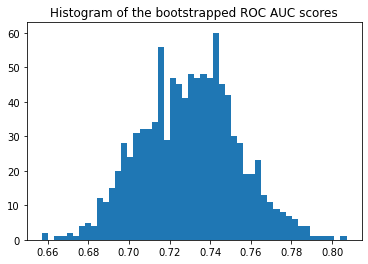

Confidence interval for the score: [0.686 - 0.778]


In [13]:
#setting X_train and y_train 
X_train = d_train.drop(columns='TenYearCHD')
y_train = d_train['TenYearCHD']

#also setting X_test and y_test while we're at it
X_test = d_test.drop(columns='TenYearCHD')
y_test = d_test['TenYearCHD']

#setting up grid search for CV
ridge = Ridge() 
alphas = np.array([1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 1, 3, 5, 7, 10, 15])
parameter_space = { 'alpha': alphas,
                    'solver': ['lbfgs', 'sag', 'newton-cg']}
clf = GridSearchCV(ridge, parameter_space, scoring='roc_auc', n_jobs=-1, cv=5)
                
#fit data
clf.fit(X_train, y_train) # X is train samples and y is the corresponding labels
print('Best parameters found:\n', clf.best_params_)

#display & record AUC
Ridge_auc, CL, CU, words = AUC_CI(X_test, y_test, clf, prob=False)
models['Ridge'] = [clf.best_params_, words, Ridge_auc, CL, CU]

### Ridge Regression with Transformed Data

Best parameters found:
 {'alpha': 1.0, 'solver': 'sag'}
Original AUC area: 0.729


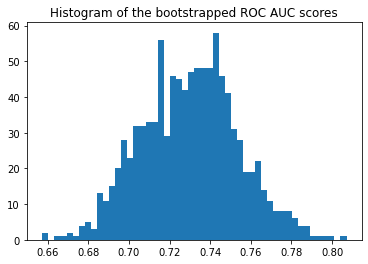

Confidence interval for the score: [0.686 - 0.778]


In [14]:
#setting X_train and y_train 
X_train = d_train.drop(columns='TenYearCHD')
y_train = d_train['TenYearCHD']

#also setting X_test and y_test while we're at it
X_test = d_test.drop(columns='TenYearCHD')
y_test = d_test['TenYearCHD']

#setting up grid search for CV
ridge = Ridge() 
alphas = np.array([1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 1, 3, 5, 7, 10, 15])
parameter_space = { 'alpha': alphas,
                    'solver': ['lbfgs', 'sag', 'newton-cg']}
clf = GridSearchCV(ridge, parameter_space, scoring='roc_auc', n_jobs=-1, cv=5)
                
#fit data
clf.fit(X_train, y_train) # X is train samples and y is the corresponding labels
print('Best parameters found:\n', clf.best_params_)

#display & record AUC
RidgeTR_auc, CL, CU, words = AUC_CI(X_test, y_test, clf, prob=False)
models['Ridge_Tranformed'] = [clf.best_params_, words, RidgeTR_auc, CL, CU]

### Exploring Variable Importance of Ridge Model (untransformed data)

In [15]:
coeffs = clf.best_estimator_.coef_
coeffs = pd.DataFrame(coeffs)
coeffs.index = list(d_train.columns)[0:-1]
coeffs

,0
sex,0.043186
age,0.007386
education,-0.002826
currentSmoker,0.001517
cigsPerDay,0.002483
BPMeds,0.017694
prevalentStroke,0.008490
prevalentHyp,0.022272
diabetes,0.018854
totChol,0.000086


## Doing some plotting for feature imp...

Text(0, 0.5, 'Coefficient Weight')

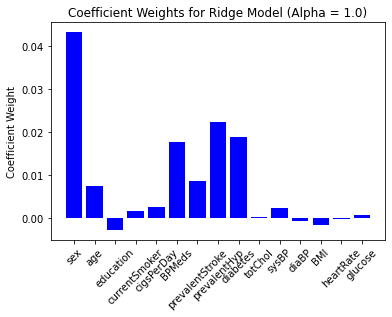

In [16]:
#plotting
fig, ax = plt.subplots()
ax.bar(list(coeffs.index), coeffs[0], color='b')
ax.set_xticklabels(labels= coeffs.index,rotation=45)
ax.set_title('Coefficient Weights for Ridge Model (Alpha = 1.0)')
ax.set_ylabel('Coefficient Weight')

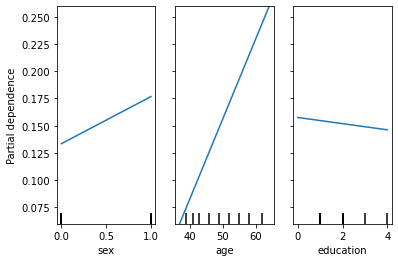

In [17]:
my_plots = plot_partial_dependence(clf, 
                                   features=[0,1,2], 
                                   X=X_train, 
                                   feature_names=X_train.columns, target=1,
                                   grid_resolution=10)

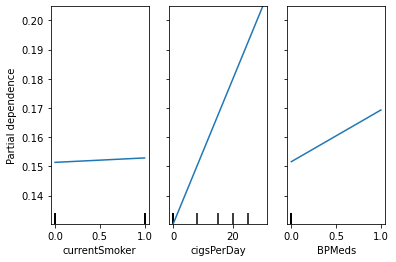

In [18]:
my_plots = plot_partial_dependence(clf, 
                                   features=[3,4,5], 
                                   X=X_train, 
                                   feature_names=X_train.columns, 
                                   grid_resolution=10)

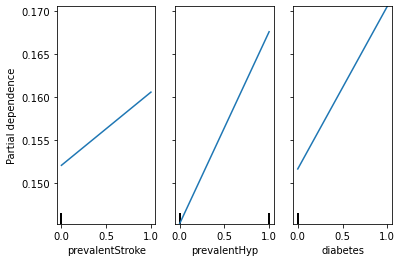

In [19]:
my_plots = plot_partial_dependence(clf, 
                                   features=[6,7,8], 
                                   X=X_train, 
                                   feature_names=X_train.columns, 
                                   grid_resolution=10)

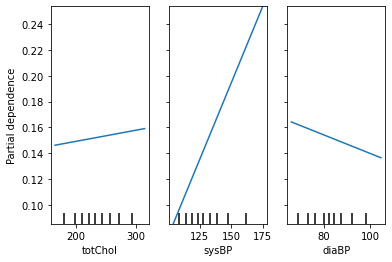

In [20]:
my_plots = plot_partial_dependence(clf, 
                                   features=[9,10,11], 
                                   X=X_train, 
                                   feature_names=X_train.columns, 
                                   grid_resolution=2)

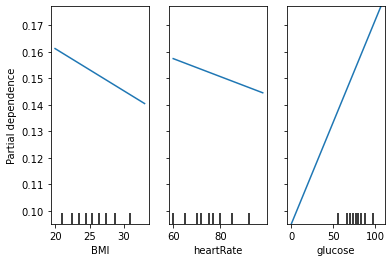

In [21]:
my_plots = plot_partial_dependence(clf, 
                                   features=[12,13,14], 
                                   X=X_train, 
                                   feature_names=X_train.columns, 
                                   grid_resolution=10)

## Feature Engineering w Ridge Regression

In [22]:
dtrainEng = d_train
dtrainEng.head()

,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
1,1,39,4,0,0,0,0,0,0,195,106.0,70.0,26.97,80,77,0
3,1,48,1,1,20,0,0,0,0,245,127.5,80.0,25.34,75,70,0
5,0,46,3,1,23,0,0,0,0,285,130.0,84.0,23.10,85,85,0
7,0,63,1,0,0,0,0,0,0,205,138.0,71.0,33.11,60,85,1
9,1,52,1,0,0,0,0,1,0,260,141.5,89.0,26.36,76,79,0


In [23]:
dtrainEng.insert(0, 'lifestyle', ((d_train.currentSmoker + d_train.prevalentStroke + d_train.prevalentHyp + d_train.diabetes)).astype(int))

In [24]:
dtrainEng = dtrainEng.drop(columns = ['currentSmoker', 'prevalentStroke', 'prevalentHyp', 'diabetes'])
dtrainEng.head()

,lifestyle,sex,age,education,cigsPerDay,BPMeds,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
1,0,1,39,4,0,0,195,106.0,70.0,26.97,80,77,0
3,1,1,48,1,20,0,245,127.5,80.0,25.34,75,70,0
5,1,0,46,3,23,0,285,130.0,84.0,23.10,85,85,0
7,0,0,63,1,0,0,205,138.0,71.0,33.11,60,85,1
9,1,1,52,1,0,0,260,141.5,89.0,26.36,76,79,0


### Repeat for test data

In [25]:
d_test.head()

,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
2,0,46,2,0,0,0,0,0,0,250,121.0,81.0,28.73,95,76,0
4,0,61,3,1,30,0,0,1,0,225,150.0,95.0,28.58,65,103,1
6,0,43,2,0,0,0,0,1,0,228,180.0,110.0,30.30,77,99,0
8,0,45,2,1,20,0,0,0,0,313,100.0,71.0,21.68,79,78,0
17,1,48,3,1,10,0,0,1,0,232,138.0,90.0,22.37,64,72,0


In [26]:
dtestEng = d_test
dtestEng.insert(0, 'lifestyle', ((dtestEng.currentSmoker + dtestEng.prevalentStroke + dtestEng.prevalentHyp + dtestEng.diabetes)).astype(int))
dtestEng.head()

,lifestyle,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
2,0,0,46,2,0,0,0,0,0,0,250,121.0,81.0,28.73,95,76,0
4,2,0,61,3,1,30,0,0,1,0,225,150.0,95.0,28.58,65,103,1
6,1,0,43,2,0,0,0,0,1,0,228,180.0,110.0,30.30,77,99,0
8,1,0,45,2,1,20,0,0,0,0,313,100.0,71.0,21.68,79,78,0
17,2,1,48,3,1,10,0,0,1,0,232,138.0,90.0,22.37,64,72,0


In [27]:
dtestEng = dtestEng.drop(columns = ['currentSmoker', 'prevalentStroke', 'prevalentHyp', 'diabetes'])
dtestEng.head()

,lifestyle,sex,age,education,cigsPerDay,BPMeds,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
2,0,0,46,2,0,0,250,121.0,81.0,28.73,95,76,0
4,2,0,61,3,30,0,225,150.0,95.0,28.58,65,103,1
6,1,0,43,2,0,0,228,180.0,110.0,30.30,77,99,0
8,1,0,45,2,20,0,313,100.0,71.0,21.68,79,78,0
17,2,1,48,3,10,0,232,138.0,90.0,22.37,64,72,0


## Remodeling with Ridge Regression using Engineered Data

Best parameters found:
 {'alpha': 10.0, 'solver': 'sag'}
Original AUC area: 0.728


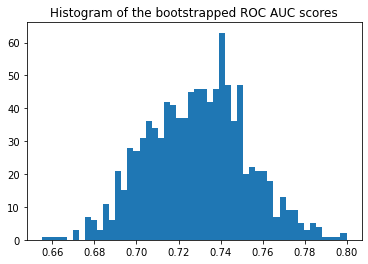

Confidence interval for the score: [0.685 - 0.776]


In [28]:
#label encoding
categories = ['education', 'lifestyle', 'BPMeds', 'sex', 'TenYearCHD']

dfs = dtrainEng, dtestEng

#use one hot encoding for outcome since xgb.DMatrix doesnt support categorical labels
for df in dfs:
    for category in categories:
        df[category] = le.fit_transform(df[category])

#setting X_train and y_train 
X_train = dtrainEng.drop(columns='TenYearCHD')
y_train = dtrainEng['TenYearCHD']

#also setting X_test and y_test while we're at it
X_test = dtestEng.drop(columns='TenYearCHD')
y_test = dtestEng['TenYearCHD']

#setting up grid search for CV
ridge = Ridge() 
alphas = np.array([1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 1, 3, 5, 7, 10, 15, 20, 25, 30])
parameter_space = { 'alpha': alphas,
                    'solver': ['lbfgs', 'sag', 'newton-cg']}
clf = GridSearchCV(ridge, parameter_space, scoring='roc_auc', n_jobs=-1, cv=5)
                
#fit data
clf.fit(X_train, y_train) # X is train samples and y is the corresponding labels
print('Best parameters found:\n', clf.best_params_)

#display & record AUC
eng_auc, CL, CU, words = AUC_CI(X_test, y_test, clf, prob=False)
models['Ridge_Engineered'] = [clf.best_params_, words, eng_auc, CL, CU]

### Re-Evaluating Feature Importance

Text(0, 0.5, 'Coefficient Weight')

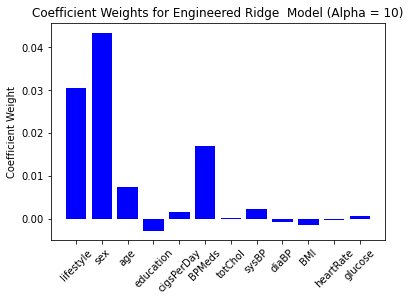

In [29]:
coeffs = clf.best_estimator_.coef_
coeffs = pd.DataFrame(coeffs)
coeffs.index = list(dtrainEng.columns)[0:-1]

#plotting
fig, ax = plt.subplots()
ax.bar(list(coeffs.index), coeffs[0], color='b')
ax.set_xticklabels(labels= coeffs.index,rotation=45)
ax.set_title('Coefficient Weights for Engineered Ridge  Model (Alpha = 10)')
ax.set_ylabel('Coefficient Weight')

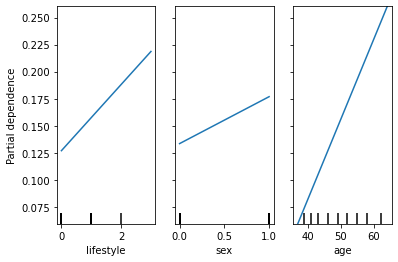

In [30]:
my_plots = plot_partial_dependence(clf, 
                                   features=[0,1,2], 
                                   X=X_train, 
                                   feature_names=X_train.columns, 
                                   grid_resolution=10)

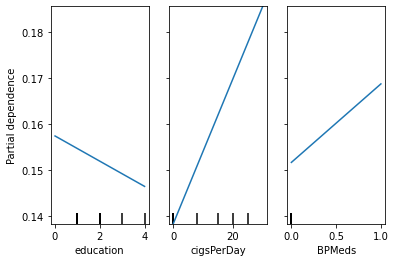

In [31]:
my_plots = plot_partial_dependence(clf, 
                                   features=[3,4,5], 
                                   X=X_train, 
                                   feature_names=X_train.columns, 
                                   grid_resolution=10)

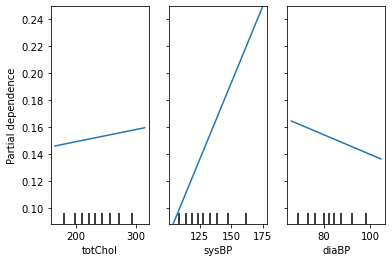

In [32]:
my_plots = plot_partial_dependence(clf, 
                                   features=[6,7,8], 
                                   X=X_train, 
                                   feature_names=X_train.columns, 
                                   grid_resolution=10)

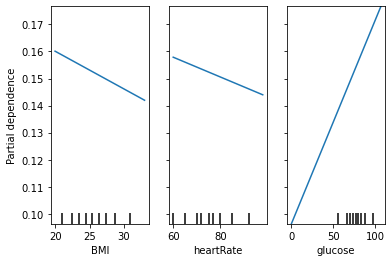

In [33]:
my_plots = plot_partial_dependence(clf, 
                                   features=[9,10,11], 
                                   X=X_train, 
                                   feature_names=X_train.columns, 
                                   grid_resolution=10)

# Elastic Net

### (Untransformed Data)

Best parameters found:
 {'alpha': 0.005, 'l1_ratio': 0.0}
Original AUC area: 0.727


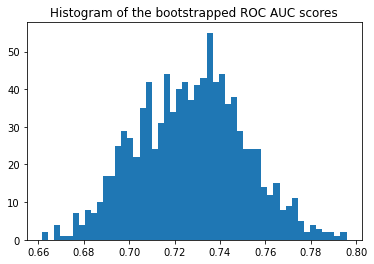

Confidence interval for the score: [0.683 - 0.774]


In [34]:
#setting X_train and y_train 
X_train = d_train.drop(columns='TenYearCHD')
y_train = d_train['TenYearCHD']

#also setting X_test and y_test while we're at it
X_test = d_test.drop(columns='TenYearCHD')
y_test = d_test['TenYearCHD']

#setting up grid search for CV
EN = ElasticNet() 
alphas = np.array([1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 1, 3, 5, 7, 10, 15])
l1_ratio = np.array([0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
parameter_space = { 'alpha': alphas,
                    'l1_ratio': l1_ratio}
clf = GridSearchCV(EN, parameter_space, scoring='roc_auc', n_jobs=-1, cv=5)
                
#fit data
clf.fit(X_train, y_train) # X is train samples and y is the corresponding labels
print('Best parameters found:\n', clf.best_params_)

#display & record AUC
EN_auc, CL, CU, words = AUC_CI(X_test, y_test, clf, prob=False)
models['ElasticNet'] = [clf.best_params_, words, EN_auc, CL, CU]

## ANN

### (resampled & standardized data)

commenting out python code for resampling/standardizing and just working with the trainTransformed and testTransformed data from Kevin.

#Now going back to the untransformed data to do some feature engineering with SMOTE and then restandardize
#set up X & Y train/test 
X_train = d_train.drop(columns='TenYearCHD')
y_train = d_train['TenYearCHD']

#also setting X_test and y_test while we're at it
X_test = d_test.drop(columns='TenYearCHD')
y_test = d_test['TenYearCHD']

#setting up smote
sm = SMOTE(sampling_strategy = "all", random_state=seed, k_neighbors=1)

#resampling data
#issues arise after changing the type of categorical columns to categorical so need to go back to original data
X_res, y_res = sm.fit_resample(X_train, y_train)

#centering and scaling data
std_scale = pp.StandardScaler().fit(X_res)
X_train_transformed = std_scale.transform(X_res)
X_test_transformed = std_scale.transform(X_test)

Best parameters found:
 {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': 30, 'learning_rate': 'constant', 'solver': 'sgd'}
Original AUC area: 0.720


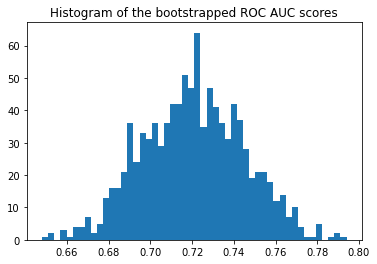

Confidence interval for the score: [0.675 - 0.768]


In [35]:
dtrain = trainTransformed
dtest = testTransformed

#label encoding
categories = ['education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'diabetes', 'sex', 'TenYearCHD']

dfs = dtrain, dtest

#use one hot encoding for outcome since xgb.DMatrix doesnt support categorical labels
for df in dfs:
    for category in categories:
        df[category] = le.fit_transform(df[category])

#set up X & Y train/test 
X_train = dtrain.drop(columns='TenYearCHD')
y_train = dtrain['TenYearCHD']

#also setting X_test and y_test while we're at it
X_test = dtest.drop(columns='TenYearCHD')
y_test = dtest['TenYearCHD']

#setting up ANN model
ann_model = mlpc(max_iter=500, tol=0.00001, random_state=seed)
parameter_space = {
    'hidden_layer_sizes': [10, 20, 25, 30], 
    'activation': ['logistic'],
    'solver': ['sgd'],
    'alpha': [0.0001],
    'learning_rate': ['constant'] #just keep constant for now for easier running
}

#setting up grid search for CV
clf = GridSearchCV(ann_model, parameter_space, scoring = 'roc_auc', n_jobs=-1, cv=5)
clf.fit(X_train, y_train) # X is train samples and y is the corresponding labels
print('Best parameters found:\n', clf.best_params_)

#display & record AUC
ANN_auc, CL, CU, words = AUC_CI(X_test, y_test, clf)
models['ANN'] = [clf.best_params_, words, ANN_auc, CL, CU]

## RF Model

### (Untransformed Data)

In [36]:
#data check
dtrain.head()

,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
4185.0,1,-1.031486,1,1,1.081409,0,0,0,0,-0.196850,-0.100680,0.172733,0.858859,0.983120,-0.375717,0
52.0,1,-0.150463,4,0,-0.805822,0,0,0,0,-0.523487,-1.157746,-1.608074,-0.527992,1.150391,0.164115,0
3515.0,0,0.856421,0,0,-0.805822,0,0,0,0,0.803475,-0.038500,-0.282822,0.748926,0.314039,-0.267750,0
4169.0,0,1.234003,1,0,-0.805822,1,0,1,0,1.701726,1.661096,1.870712,1.943394,-0.104136,-0.138191,0
2913.0,0,-1.660789,2,0,-0.805822,0,0,0,0,0.211446,-0.618850,0.048490,-1.105142,-0.104136,0.120929,0


RandomForestClassifier(max_features=5, n_estimators=1000, random_state=27)

Best parameters found:
 {'max_features': 5, 'n_estimators': 1000}
Original AUC area: 0.706


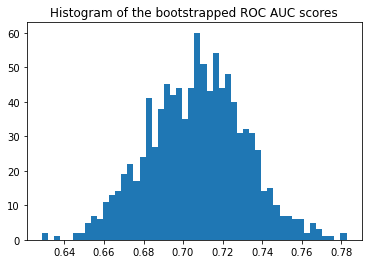

Confidence interval for the score: [0.660 - 0.755]


In [37]:
#set up X & Y train/test 
X_train = dtrain.drop(columns='TenYearCHD')
y_train = dtrain['TenYearCHD']

#also setting X_test and y_test while we're at it
X_test = dtest.drop(columns='TenYearCHD')
y_test = dtest['TenYearCHD']

#determining ~m_try (sqrt(p) +/- 2)
p_sqrt = isqrt(len(X_train.columns)) #isquareroot returns an integer value -- rounded down to a whole number
#can use max_featues = "sqrt" but this doesnt search for up to sqrt(n_features)+2 which is what we want

#creating hyperparameter grid
parameter_space = {
    'n_estimators': [500, 1000], #num of trees
    'max_features': [p_sqrt+2], #num of features to consider per split
}

#other params to consider tuning from docs:
    #criterion -- "gini", "entropy" etc, default = gini -- how to measure quality of split
    #max_depth  -- default = None -- max depth of tree
    #min_samples_split =2 -- min num of samples to split a node
    #random_state
    #bootstrap -- wheter to boostrap when building trees


#setting model choice
rfc=RandomForestClassifier(random_state=seed)

#setting up grid search for CV
clf = GridSearchCV(rfc, parameter_space, scoring='roc_auc', n_jobs=-1, cv=5)
bestRF = clf.fit(X_train, y_train) # X is train samples and y is the corresponding labels
best_grid = clf.best_estimator_
print(best_grid)
print('\nBest parameters found:\n', clf.best_params_)

#display & record AUC
RF_auc, CL, CU, words = AUC_CI(X_test, y_test, clf)
models['RF'] = [str(clf.best_params_), words, RF_auc, CL, CU]

In [38]:
#feat imp in RF model
fi = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': best_grid.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head()

,feature,importance
1,age,0.179621
10,sysBP,0.145687
4,cigsPerDay,0.103932
14,glucose,0.098786
9,totChol,0.083752


Text(0.5, 0, 'Random Forest Feature Importance')

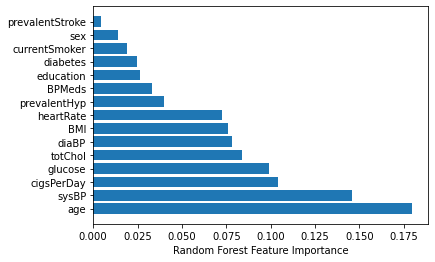

In [39]:
plt.barh(fi.feature, fi.importance)
plt.xlabel('Random Forest Feature Importance')

In [40]:
#formatting data table for AUC values
models_df = pd.DataFrame(models)
models_df = models_df.T
models_df = models_df.rename(index={'Ridge_Tranformed':'Ridge_Transformed'})
models_df.columns = ['Best Parameters', 'AUC (95% CI)', 'AUC', 'CL', 'CU' ]
models_df[['err']]  = (models_df.CU - models_df.CL)/2
pd.set_option("display.max_colwidth", None)
models_df

,Best Parameters,AUC (95% CI),AUC,CL,CU,err
LR,{'solver': 'lbfgs'},"0.660 (0.611, 0.712)",0.660232,0.611488,0.712469,0.0504908
Lasso,{'alpha': 0.0001},"0.726 (0.682, 0.773)",0.726465,0.682158,0.773122,0.0454823
Ridge,"{'alpha': 1.0, 'solver': 'sag'}","0.729 (0.686, 0.778)",0.729446,0.685859,0.777822,0.0459811
Ridge_Transformed,"{'alpha': 1.0, 'solver': 'sag'}","0.729 (0.686, 0.778)",0.729457,0.685839,0.777798,0.045979
Ridge_Engineered,"{'alpha': 10.0, 'solver': 'sag'}","0.728 (0.685, 0.776)",0.728423,0.684579,0.776139,0.0457798
ElasticNet,"{'alpha': 0.005, 'l1_ratio': 0.0}","0.727 (0.683, 0.774)",0.72666,0.682699,0.773955,0.0456283
ANN,"{'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': 30, 'learning_rate': 'constant', 'solver': 'sgd'}","0.720 (0.675, 0.768)",0.720317,0.675385,0.767945,0.0462802
RF,"{'max_features': 5, 'n_estimators': 1000}","0.706 (0.660, 0.755)",0.706297,0.65981,0.755061,0.0476254


In [41]:
models_short = models_df[['Best Parameters', 'AUC (95% CI)']]
pd.set_option("display.max_colwidth", 100)
models_short

,Best Parameters,AUC (95% CI)
LR,{'solver': 'lbfgs'},"0.660 (0.611, 0.712)"
Lasso,{'alpha': 0.0001},"0.726 (0.682, 0.773)"
Ridge,"{'alpha': 1.0, 'solver': 'sag'}","0.729 (0.686, 0.778)"
Ridge_Transformed,"{'alpha': 1.0, 'solver': 'sag'}","0.729 (0.686, 0.778)"
Ridge_Engineered,"{'alpha': 10.0, 'solver': 'sag'}","0.728 (0.685, 0.776)"
ElasticNet,"{'alpha': 0.005, 'l1_ratio': 0.0}","0.727 (0.683, 0.774)"
ANN,"{'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': 30, 'learning_rate': 'constant...","0.720 (0.675, 0.768)"
RF,"{'max_features': 5, 'n_estimators': 1000}","0.706 (0.660, 0.755)"


Text(0.5, 1.0, 'AUC (95% CI) of Various Machine Learning Models')

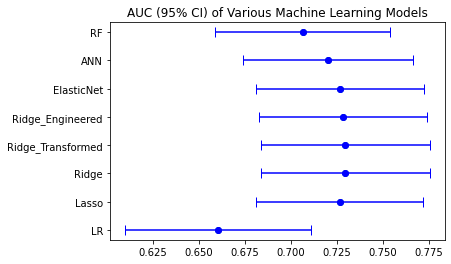

In [42]:
fig, ax = plt.subplots()
ax.scatter(pd.to_numeric(models_df.AUC), list(models_df.index))
ax.errorbar(pd.to_numeric(models_df.AUC), list(models_df.index), xerr = pd.to_numeric(models_df.err), fmt="o", capsize=5, color='blue')
ax.set_title('AUC (95% CI) of Various Machine Learning Models')